# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [32]:
import warnings

warnings.filterwarnings('ignore')

## Data Handling
import pandas as pd
import numpy as np

## Visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.tsa.api as tsa
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

## Settings
%matplotlib inline
plt.rcParams['figure.figsize']=(12,6)
plt.style.use('seaborn-talk')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('max_rows', 100)

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
from bmc_functions import eda

In [35]:
source = '../data/zillow_data.csv'
data = pd.read_csv(source)
data.head(5)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,"334,200.00","335,400.00","336,500.00","337,600.00","338,500.00","339,500.00","340,400.00","341,300.00","342,600.00","344,400.00","345,700.00","346,700.00","347,800.00","349,000.00","350,400.00","352,000.00","353,900.00","356,200.00","358,800.00","361,800.00","365,700.00","370,200.00","374,700.00","378,900.00","383,500.00","388,300.00","393,300.00","398,500.00","403,800.00","409,100.00","414,600.00","420,100.00","426,200.00","432,600.00","438,600.00","444,200.00","450,000.00","455,900.00","462,100.00","468,500.00","475,300.00","482,500.00","490,200.00","498,200.00","507,200.00","516,800.00","526,300.00","535,300.00","544,500.00","553,500.00","562,400.00","571,200.00","579,800.00","588,100.00","596,300.00","604,200.00","612,200.00","620,200.00","627,700.00","634,500.00","641,000.00","647,000.00","652,700.00","658,100.00","663,300.00","668,400.00","673,400.00","678,300.00","683,200.00","688,300.00","693,300.00","698,000.00","702,400.00","706,400.00","710,200.00","714,000.00","717,800.00","721,700.00","725,700.00","729,900.00","733,400.00","735,600.00","737,200.00","739,000.00","740,900.00","742,700.00","744,400.00","746,000.00","747,200.00","748,000.00","749,000.00","750,200.00","752,300.00","755,300.00","759,200.00","764,000.00","769,600.00","775,600.00","781,900.00","787,900.00","793,200.00","798,200.00","803,100.00","807,900.00","812,900.00","818,100.00","823,100.00","828,300.00","834,100.00","839,800.00","845,600.00","851,800.00","858,000.00","864,400.00","870,700.00","876,200.00","880,700.00","884,400.00","887,600.00","890,500.00","893,300.00","895,500.00","897,300.00","899,000.00","900,400.00","902,000.00","904,400.00","907,100.00","909,700.00","911,900.00","913,000.00","913,000.00","912,000.00","909,300.00","905,300.00","901,400.00","897,900.00","

In [36]:
ca_data = data[data["State"] == "CA"]
ca_data

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,"766,000.00","771,100.00","776,500.00","781,900.00","787,300.00","793,000.00","799,100.00","805,800.00","814,400.00","824,300.00","833,800.00","842,900.00","852,900.00","863,500.00","874,800.00","886,500.00","898,200.00","910,200.00","922,800.00","936,100.00","951,500.00","968,400.00","984,900.00","1,001,100.00","1,018,700.00","1,037,200.00","1,056,700.00","1,076,900.00","1,097,300.00","1,118,200.00","1,139,800.00","1,162,400.00","1,187,600.00","1,214,200.00","1,240,400.00","1,266,500.00","1,294,400.00","1,323,300.00","1,353,300.00","1,384,000.00","1,414,800.00","1,445,800.00","1,477,300.00","1,509,700.00","1,544,400.00","1,580,300.00","1,614,900.00","1,648,100.00","1,681,900.00","1,715,200.00","1,748,100.00","1,779,600.00","1,809,200.00","1,836,700.00","1,862,900.00","1,888,300.00","1,913,400.00","1,937,300.00","1,958,700.00","1,978,500.00","1,997,500.00","2,015,400.00","2,032,000.00","2,046,500.00","2,058,400.00","2,068,400.00","2,077,400.00","2,086,300.00","2,094,900.00","2,102,900.00","2,110,000.00","2,117,200.00","2,124,300.00","2,131,500.00","2,138,600.00","2,144,500.00","2,148,300.00","2,150,900.00","2,154,300.00","2,155,300.00","2,150,200.00","2,141,100.00","2,130,800.00","2,119,000.00","2,106,400.00","2,096,600.00","2,091,500.00","2,089,600.00","2,089,100.00","2,091,900.00","2,101,700.00","2,122,200.00","2,154,900.00","2,195,700.00","2,238,900.00","2,280,100.00","2,314,800.00","2,340,400.00","2,360,300.00","2,380,700.00","2,405,800.00","2,435,000.00","2,464,500.00","2,491,200.00","2,515,000.00","2,534,800.00","2,549,600.00","2,560,400.00","2,564,000.00","2,556,800.00","2,540,300.00","2,518,200.00","2,494,000.00","2,474,300.00","2,459,700.00","2,446,000.00","2,432,400.00","2,418,700.00","2,402,600.00","2,387,800.00","2,375

In [37]:
## Inspecting single zipcode values

ca_data[ca_data['RegionName'] == 90001]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
2696,95982,90001,Florence-Graham,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,2697,"117,700.00","117,800.00","117,900.00","117,900.00","118,000.00","117,900.00","117,900.00","117,900.00","118,000.00","118,200.00","118,300.00","118,200.00","118,100.00","117,900.00","117,800.00","117,700.00","117,600.00","117,600.00","117,700.00","117,900.00","118,300.00","118,800.00","119,300.00","119,600.00","119,900.00","120,200.00","120,500.00","120,800.00","121,000.00","121,300.00","121,700.00","122,100.00","122,600.00","123,200.00","123,900.00","124,400.00","124,800.00","125,200.00","125,600.00","125,900.00","126,200.00","126,500.00","127,000.00","127,400.00","128,100.00","128,800.00","129,400.00","129,900.00","130,500.00","130,900.00","131,300.00","131,600.00","132,000.00","132,300.00","132,700.00","133,100.00","133,500.00","134,000.00","134,600.00","135,100.00","135,400.00","135,700.00","136,000.00","136,200.00","136,500.00","136,800.00","137,400.00","138,000.00","138,900.00","140,000.00","141,300.00","142,500.00","143,700.00","145,000.00","146,300.00","147,600.00","149,000.00","150,400.00","152,000.00","153,900.00","155,900.00","157,600.00","159,100.00","161,000.00","163,100.00","165,500.00","168,000.00","170,500.00","173,300.00","176,200.00","179,300.00","182,600.00","186,100.00","189,800.00","193,600.00","197,700.00","202,200.00","207,200.00","212,800.00","218,900.00","225,200.00","231,600.00","238,100.00","244,400.00","250,900.00","257,500.00","264,200.00","270,900.00","278,000.00","285,000.00","292,300.00","299,900.00","307,500.00","314,900.00","322,000.00","328,400.00","334,400.00","340,200.00","345,900.00","352,000.00","358,700.00","365,500.00","372,300.00","378,300.00","383,200.00","387,300.00","390,700.00","393,000.00","394,400.00","395,400.00","395,900.00","396,100.00","396,400.00","396,600.

In [38]:
## Inspecting overall data for California

data[data["State"] == "CA"].pivot_table(index= 'RegionName')

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,RegionID,SizeRank
RegionName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
90001,"117,700.00","117,800.00","117,900.00","117,900.00","118,000.00","117,900.00","117,900.00","117,900.00","118,000.00","118,200.00","118,300.00","118,200.00","118,100.00","117,900.00","117,800.00","117,700.00","117,600.00","117,600.00","117,700.00","117,900.00","118,300.00","118,800.00","119,300.00","119,600.00","119,900.00","120,200.00","120,500.00","120,800.00","121,000.00","121,300.00","121,700.00","122,100.00","122,600.00","123,200.00","123,900.00","124,400.00","124,800.00","125,200.00","125,600.00","125,900.00","126,200.00","126,500.00","127,000.00","127,400.00","128,100.00","128,800.00","129,400.00","129,900.00","130,500.00","130,900.00","131,300.00","131,600.00","132,000.00","132,300.00","132,700.00","133,100.00","133,500.00","134,000.00","134,600.00","135,100.00","135,400.00","135,700.00","136,000.00","136,200.00","136,500.00","136,800.00","137,400.00","138,000.00","138,900.00","140,000.00","141,300.00","142,500.00","143,700.00","145,000.00","146,300.00","147,600.00","149,000.00","150,400.00","152,000.00","153,900.00","155,900.00","157,600.00","159,100.00","161,000.00","163,100.00","165,500.00","168,000.00","170,500.00","173,300.00","176,200.00","179,300.00","182,600.00","186,100.00","189,800.00","193,600.00","197,700.00","202,200.00","207,200.00","212,800.00","218,900.00","225,200.00","231,600.00","238,100.00","244,400.00","250,900.00","257,500.00","264,200.00","270,900.00","278,000.00","285,000.00","292,300.00","299,900.00","307,500.00","314,900.00","322,000.00","328,400.00","334,400.00","340,200.00","345,900.00","352,000.00","358,700.00","365

In [39]:
## Inspecting overall data for CA - transposed and dropping RegionID, SizeRank

ca_zips = data[data["State"] == "CA"].pivot_table(index= 'RegionName').T[:-2]
ca_zips

RegionName      90001      90002      90003        90004        90005  \
1996-04    117,700.00 110,600.00 111,400.00   240,200.00   249,100.00   
1996-05    117,800.00 110,600.00 111,100.00   240,700.00   250,600.00   
1996-06    117,900.00 110,600.00 110,800.00   241,200.00   252,200.00   
1996-07    117,900.00 110,600.00 110,500.00   241,700.00   253,800.00   
1996-08    118,000.00 110,700.00 110,200.00   242,200.00   255,600.00   
...               ...        ...        ...          ...          ...   
2017-12    351,000.00 351,000.00 350,900.00 1,530,600.00 1,453,900.00   
2018-01    354,900.00 354,400.00 353,100.00 1,546,500.00 1,458,800.00   
2018-02    356,900.00 357,500.00 354,700.00 1,559,700.00 1,476,200.00   
2018-03    358,400.00 360,600.00 356,700.00 1,567,700.00 1,514,300.00   
2018-04    359,900.00 362,300.00 358,400.00 1,571,600.00 1,547,100.00   

RegionName      90006      90007      90008      90011      90012      90013  \
1996-04    134,100.00 137,900.00 182,200.00 114,000.00 121,000.00        nan   
1996-05    134,000.00 138,500.00 181,800.00 114,000.00 121,000.00        nan   
1996-06    133,900.00 139,100.00 181,200.00 114,000.00 120,900.00        nan   
1996-07    133,800.00 139,700.00 180,600.00 114,000.00 120,800.00        nan   
1996-08    133,600.00 140,400.00 179,900.00 114,100.00 120,700.00        nan   
...               ...        ...        ...        ...        ...        ...   
2017-12    731,900.00 616,300.00 781,600.00 372,200.00 626,100.00 602,800.00   
2018-01    736,700.00 624,500.00 792,000.00 374,200.00 627,900.00 612,400.00   
2018-02    750,100.00 629,100.00 800,600.00 376,300.00 625,800.00 614,500.00   
2018-03    774,100.00 634,300.00 807,200.00 378,000.00 620,800.00 603,100.00   
2018-04    790,800.00 639,600.00 809,500.00 377,800.00 617,700.00 589,900.00   

RegionName      90014      90015      90016      90017      90018  \
1996-04           nan 140,200.00 135,700.00 159,300.00 133,200.00   
1996-05           nan 140,300.00 135,300.00 160,200.00 132,900.00   
1996-06           nan 140,500.00 134,900.00 161,100.00 132,400.00   
1996-07           nan 140,600.00 134,400.00 162,000.00 131,900.00   
1996-08           nan 140,800.00 133,900.00 162,900.00 131,500.00   
...               ...        ...        ...        ...        ...   
2017-12    694,700.00 588,600.00 692,200.00 633,600.00 640,300.00   
2018-01    696,400.00 601,500.00 706,500.00 642,600.00 643,100.00   
2018-02    694,000.00 606,700.00 715,900.00 649,900.00 646,400.00   
2018-03    691,700.00 607,100.00 722,000.00 654,200.00 652,700.00   
2018-04    689,600.00 605,000.00 727,400.00 656,400.00 658,000.00   

RegionName        90019        90020      90022      90023        90024  \
1996-04      168,800.00   711,600.00 144,800.00 127,500.00   669,700.00   
1996-05      168,200.00   717,100.00 144,600.00 127,700.00   672,100.00   
1996-06      167,500.00   722,400.00 144,400.00 127,800.00   674,600.00   
1996-07      167,000.00   727,500.00 144,200.00 128,000.00   677,100.00   
1996-08      166,400.00   732,700.00 143,900.00 128,200.00   679,800.00   
...                 ...          ...        ...        ...          ...   
2017-12    1,047,700.00 3,730,900.00 429,800.00 403,900.00 2,761,000.00   
2018-01    1,072,400.00 3,760,500.00 430,100.00 405,400.00 2,789,400.00   
2018-02    1,091,000.00 3,785,500.00 432,000.00 407,100.00 2,818,200.00   
2018-03    1,104,000.00 3,819,900.00 436,100.00 408,200.00 2,847,200.00   
2018-04    1,112,400.00 3,842,700.00 438,500.00 407,800.00 2,864,100.00   

RegionName        90025      90026        90027        90028      90029  \
1996-04      330,200.00 138,100.00   295,800.00   165,500.00 145,700.00   
1996-05      330,900.00 138,300.00   295,700.00   166,300.00 146,000.00   
1996-06      331,700.00 138,300.00   295,600.00   167,200.00 146,200.00   
1996-07      332,500.00 138,300.00   295,500.00   168,000.00 146,400.00   
1996-08      333,400.00 138,300.00   295,500.00   168,900

# Step 2: Data Preprocessing

In [40]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.index.values, format='%Y-%m')

In [41]:
dt_idx = get_datetimes(ca_zips)
dt_idx

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [42]:
ca_zips.set_index(dt_idx, inplace=True)

In [43]:
ca_zips.columns.name = None

In [44]:
ca_zips

90001      90002      90003        90004        90005  \
1996-04-01 117,700.00 110,600.00 111,400.00   240,200.00   249,100.00   
1996-05-01 117,800.00 110,600.00 111,100.00   240,700.00   250,600.00   
1996-06-01 117,900.00 110,600.00 110,800.00   241,200.00   252,200.00   
1996-07-01 117,900.00 110,600.00 110,500.00   241,700.00   253,800.00   
1996-08-01 118,000.00 110,700.00 110,200.00   242,200.00   255,600.00   
...               ...        ...        ...          ...          ...   
2017-12-01 351,000.00 351,000.00 350,900.00 1,530,600.00 1,453,900.00   
2018-01-01 354,900.00 354,400.00 353,100.00 1,546,500.00 1,458,800.00   
2018-02-01 356,900.00 357,500.00 354,700.00 1,559,700.00 1,476,200.00   
2018-03-01 358,400.00 360,600.00 356,700.00 1,567,700.00 1,514,300.00   
2018-04-01 359,900.00 362,300.00 358,400.00 1,571,600.00 1,547,100.00   

                90006      90007      90008      90011      90012      90013  \
1996-04-01 134,100.00 137,900.00 182,200.00 114,000.00 121,000.00        nan   
1996-05-01 134,000.00 138,500.00 181,800.00 114,000.00 121,000.00        nan   
1996-06-01 133,900.00 139,100.00 181,200.00 114,000.00 120,900.00        nan   
1996-07-01 133,800.00 139,700.00 180,600.00 114,000.00 120,800.00        nan   
1996-08-01 133,600.00 140,400.00 179,900.00 114,100.00 120,700.00        nan   
...               ...        ...        ...        ...        ...        ...   
2017-12-01 731,900.00 616,300.00 781,600.00 372,200.00 626,100.00 602,800.00   
2018-01-01 736,700.00 624,500.00 792,000.00 374,200.00 627,900.00 612,400.00   
2018-02-01 750,100.00 629,100.00 800,600.00 376,300.00 625,800.00 614,500.00   
2018-03-01 774,100.00 634,300.00 807,200.00 378,000.00 620,800.00 603,100.00   
2018-04-01 790,800.00 639,600.00 809,500.00 377,800.00 617,700.00 589,900.00   

                90014      90015      90016      90017      90018  \
1996-04-01        nan 140,200.00 135,700.00 159,300.00 133,200.00   
1996-05-01        nan 140,300.00 135,300.00 160,200.00 132,900.00   
1996-06-01        nan 140,500.00 134,900.00 161,100.00 132,400.00   
1996-07-01        nan 140,600.00 134,400.00 162,000.00 131,900.00   
1996-08-01        nan 140,800.00 133,900.00 162,900.00 131,500.00   
...               ...        ...        ...        ...        ...   
2017-12-01 694,700.00 588,600.00 692,200.00 633,600.00 640,300.00   
2018-01-01 696,400.00 601,500.00 706,500.00 642,600.00 643,100.00   
2018-02-01 694,000.00 606,700.00 715,900.00 649,900.00 646,400.00   
2018-03-01 691,700.00 607,100.00 722,000.00 654,200.00 652,700.00   
2018-04-01 689,600.00 605,000.00 727,400.00 656,400.00 658,000.00   

                  90019        90020      90022      90023        90024  \
1996-04-01   168,800.00   711,600.00 144,800.00 127,500.00   669,700.00   
1996-05-01   168,200.00   717,100.00 144,600.00 127,700.00   672,100.00   
1996-06-01   167,500.00   722,400.00 144,400.00 127,800.00   674,600.00   
1996-07-01   167,000.00   727,500.00 144,200.00 128,000.00   677,100.00   
1996-08-01   166,400.00   732,700.00 143,900.00 128,200.00   679,800.00   
...                 ...          ...        ...        ...          ...   
2017-12-01 1,047,700.00 3,730,900.00 429,800.00 403,900.00 2,761,000.00   
2018-01-01 1,072,400.00 3,760,500.00 430,100.00 405,400.00 2,789,400.00   
2018-02-01 1,091,000.00 3,785,500.00 432,000.00 407,100.00 2,818,200.00   
2018-03-01 1,104,000.00 3,819,900.00 436,100.00 408,200.00 2,847,200.00   
2018-04-01 1,112,400.00 3,842,700.00 438,500.00 407,800.00 2,864,100.00   

                  90025      90026        90027        90028      90029  \
1996-04-01   330,200.00 138,100.00   295,800.00   165,500.00 145,700.00   
1996-05-01   330,900.00 138,300.00   295,700.00   166,300.00 146,000.00   
1996-06-01   331,700.00 138,300.00   295,600.00   167,200.00 146,200.00   
1996-07-01   332,500.00 138,300.00   295,500.00   168,000.00 146,400.00   
1996-08-01   333,400.00 138,300.00   295,500.00   168,900.00 146,600.00  

# Step 3: EDA and Visualization

In [45]:
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

# mpl.rc('font', **font)

# # NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [46]:
## Generating initial statistical overview
report = eda.report_df(ca_zips)
report

,null_sum,null_pct,datatypes,num_unique,count,mean,std,min,25%,50%,75%,max
90001,0,0.00,float64,244,265.00,"219,070.57","86,832.42","117,600.00","137,400.00","187,600.00","286,400.00","396,600.00"
90002,0,0.00,float64,246,265.00,"214,996.60","85,881.30","110,600.00","135,700.00","183,900.00","285,100.00","387,000.00"
90003,0,0.00,float64,245,265.00,"218,279.25","89,406.28","109,900.00","134,700.00","187,100.00","288,000.00","401,200.00"
90004,0,0.00,float64,261,265.00,"830,511.32","360,757.75","240,200.00","505,800.00","869,600.00","1,036,400.00","1,571,600.00"
90005,0,0.00,float64,261,265.00,"889,908.68","371,957.26","249,100.00","538,200.00","925,500.00","1,196,600.00","1,547,100.00"
...,...,...,...,...,...,...,...,...,...,...,...,...
96145,0,0.00,float64,256,265.00,"567,050.19","186,568.56","214,700.00","468,000.00","605,100.00","721,000.00","861,700.00"
96146,0,0.00,float64,254,265.00,"706,029.43","212,492.32","259,100.00","658,200.00","786,100.00","827,900.00","1,057,800.00"
96148,0,0.00,float64,257,265.00,"447,572.45","137,601.66","180,100.00","383,700.00","472,000.00","549,000.00","674,600.00"
96150,0,0.00,float64,258,265.00,"297,626.04","101,569.19","132,400.00","241,400.00","302,200.00","373,900.00","480,000.00"


In [47]:
## Inspecting only zip codes with missing columns
report[report['null_sum'] >0]

,null_sum,null_pct,datatypes,num_unique,count,mean,std,min,25%,50%,75%,max
90013,207,0.78,float64,58,58.00,"523,289.66","69,172.32","396,700.00","448,900.00","527,800.00","591,175.00","614,500.00"
90014,207,0.78,float64,56,58.00,"595,605.17","83,105.61","434,000.00","522,325.00","641,550.00","660,050.00","696,400.00"
93268,213,0.80,float64,42,52.00,"91,673.08","4,068.49","85,300.00","88,275.00","90,250.00","94,425.00","102,500.00"
93301,213,0.80,float64,46,52.00,"178,651.92","9,502.41","159,400.00","175,750.00","180,150.00","183,600.00","198,500.00"
93529,87,0.33,float64,170,178.00,"372,693.82","70,371.15","259,200.00","321,725.00","357,400.00","423,850.00","515,600.00"
93546,87,0.33,float64,174,178.00,"639,113.48","117,478.73","465,700.00","561,125.00","598,600.00","726,775.00","882,300.00"
93553,171,0.65,float64,83,94.00,"168,218.09","26,754.80","132,700.00","144,775.00","160,800.00","187,200.00","233,700.00"
93604,213,0.80,float64,51,52.00,"542,257.69","33,621.96","481,600.00","516,275.00","544,000.00","572,550.00","595,100.00"
93640,201,0.76,float64,57,64.00,"125,643.75","16,307.03","97,600.00","108,200.00","127,650.00","138,775.00","153,300.00"
93660,201,0.76,float64,60,64.00,"127,203.12","21,496.53","86,600.00","110,800.00","126,050.00","148,125.00","160,400.00"


In [48]:
## Selecting zipcode with largest number of entries
most_freq_zip = report['count'].sort_values(ascending=False)[:1]
most_freq_zip

96161   265.00
Name: count, dtype: float64

In [49]:
## Checking for missing values pre-visualizing
ca_zips[96161].isna().sum()

0

In [50]:
test_zip = ca_zips[96161]

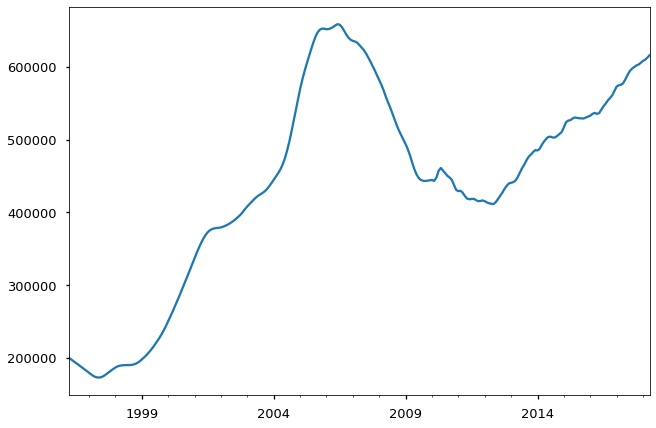

In [51]:
## Initial visualization of one zipcode
test_zip.plot();

# ❌ FIX/REMOVE JMI FUNCTION

In [52]:
## Lab Function
# from statsmodels.tsa.stattools import adfuller

def adfuller_test_df(ts,index=['AD Fuller Results']):
    """Returns the AD Fuller Test Results and p-values for the null hypothesis
    that there the data is non-stationary (that there is a unit root in the data)"""
    
    df_res = tsa.stattools.adfuller(ts)
    
    names = ['Test Statistic','p-value','#Lags Used','# of Observations Used']
    res  = dict(zip(names,df_res[:4]))
    
    res['p<.05'] = res['p-value']<.05
    res['Stationary?'] = res['p<.05']
    
    if isinstance(index,str):
        index = [index]
    res_df = pd.DataFrame(res,index=index)
    res_df = res_df[['Test Statistic','#Lags Used',
                     '# of Observations Used','p-value','p<.05',
                    'Stationary?']]
    return res_df



def stationarity_check(TS,window=8,plot=True,index=['AD Fuller Results']):
    """Adapted from https://github.com/learn-co-curriculum/dsc-removing-trends-lab/tree/solution"""
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=window, center=False).mean()
    roll_std = TS.rolling(window=window, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller_test_df(TS,index=index)
    
    if plot:
        # Plot rolling statistics:
        fig = plt.figure(figsize=(12,6))
        plt.plot(TS, color='blue',label=f'Original (freq={TS.index.freq})')
        plt.plot(roll_mean, color='red', label=f'Rolling Mean (window={window})')
        plt.plot(roll_std, color='black', label = f'Rolling Std (window={window})')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        display(dftest)
        plt.show(block=False)
        
    return dftest
    

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-2.30,15,249,0.17,False,False


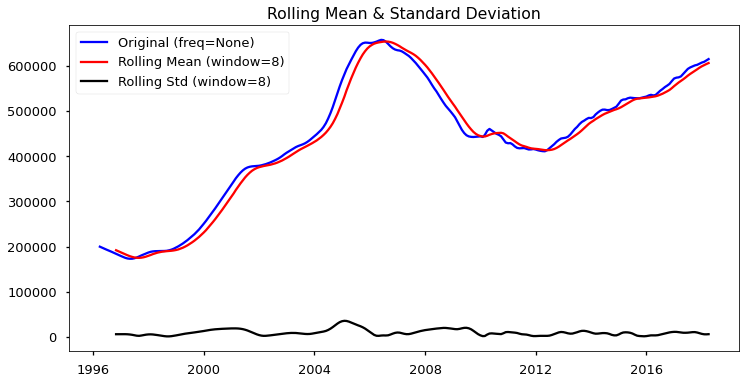

In [53]:
from statsmodels.tsa.stattools import adfuller
results = stationarity_check(test_zip)

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-2.16,14,249,0.22,False,False


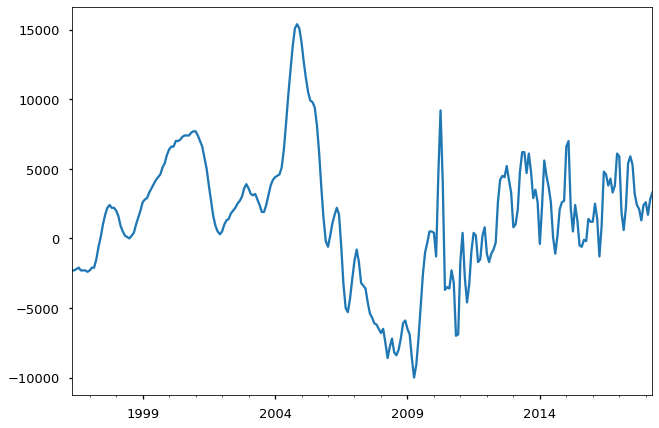

In [54]:
tz_diff = test_zip.diff().dropna()
tz_diff.plot()
adfuller_test_df(tz_diff)

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-2.84,15,249,0.05,False,False


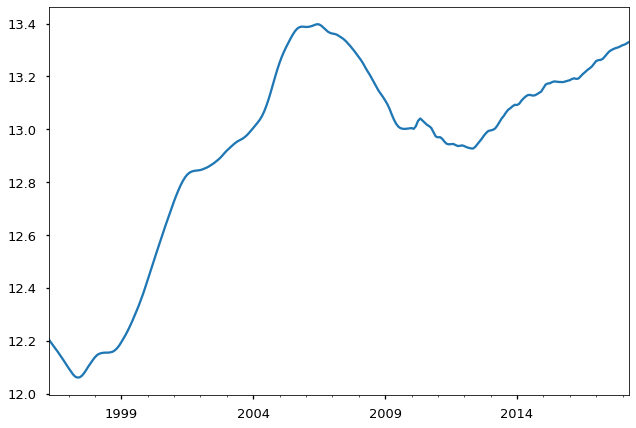

In [55]:
## Log Transform, plot and get adfuller test
tz_log = np.log(test_zip)
tz_log.plot()
adfuller_test_df(tz_log)

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-2.30,15,246,0.17,False,False


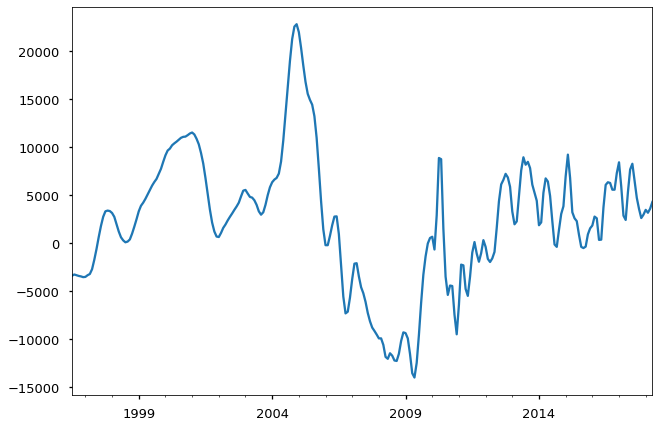

In [56]:
## Subtract Rolling mean
tz_rm = test_zip - test_zip.rolling(window=4).mean()
tz_rm.dropna(inplace=True)
tz_rm.plot()
adfuller_test_df(tz_rm)

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-2.52,15,249,0.11,False,False


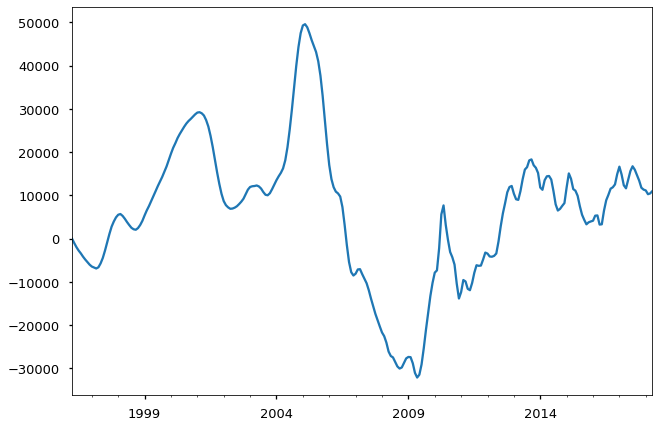

In [57]:
tz_ewm = test_zip-test_zip.ewm(4).mean()
tz_ewm.dropna(inplace=True)
tz_ewm.plot()
adfuller_test_df(tz_ewm)

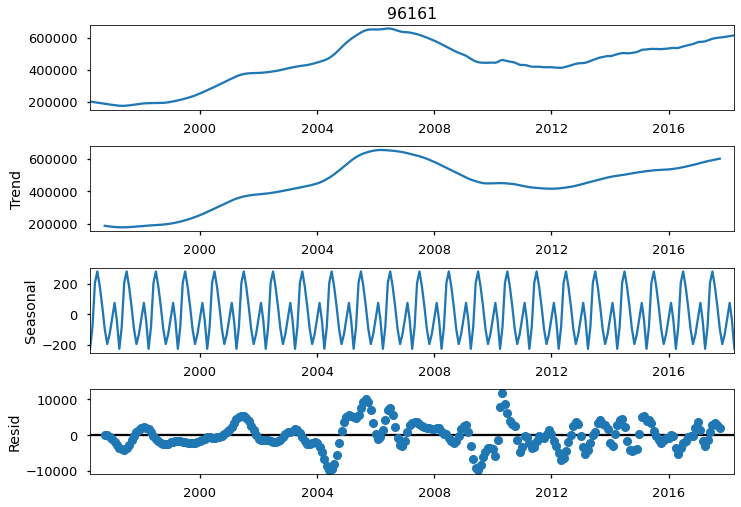

In [58]:
decomp = seasonal_decompose(test_zip)
decomp.plot();

In [59]:
decomp.seasonal

1996-04-01   -225.86
1996-05-01    -82.21
1996-06-01    206.68
1996-07-01    281.09
1996-08-01    181.09
               ...  
2017-12-01   -130.82
2018-01-01    -27.05
2018-02-01     75.14
2018-03-01    -37.76
2018-04-01   -225.86
Name: seasonal, Length: 265, dtype: float64

In [60]:
## Save seasonal/trend/resid in a dictionary.

decomp_dict = {'seasonal': decomp.seasonal,
              "trend": decomp.trend,
              'residuals': decomp.resid}

decomp_dict

{'seasonal': 1996-04-01   -225.86
 1996-05-01    -82.21
 1996-06-01    206.68
 1996-07-01    281.09
 1996-08-01    181.09
                ...  
 2017-12-01   -130.82
 2018-01-01    -27.05
 2018-02-01     75.14
 2018-03-01    -37.76
 2018-04-01   -225.86
 Name: seasonal, Length: 265, dtype: float64, 'trend': 1996-04-01   nan
 1996-05-01   nan
 1996-06-01   nan
 1996-07-01   nan
 1996-08-01   nan
               ..
 2017-12-01   nan
 2018-01-01   nan
 2018-02-01   nan
 2018-03-01   nan
 2018-04-01   nan
 Name: trend, Length: 265, dtype: float64, 'residuals': 1996-04-01   nan
 1996-05-01   nan
 1996-06-01   nan
 1996-07-01   nan
 1996-08-01   nan
               ..
 2017-12-01   nan
 2018-01-01   nan
 2018-02-01   nan
 2018-03-01   nan
 2018-04-01   nan
 Name: resid, Length: 265, dtype: float64}

In [61]:
## Make a list of adfuller results to append
results = []
## Save results of orig ts
results.append(adfuller_test_df(test_zip,index=['Original']))

## Loop through decomp dict, 
for trend, ts_ in decomp_dict.items():
    # Fill any missing values, get adfuller result
    ts_ = ts_.fillna(0)
    res = adfuller_test_df(ts_,index=trend)
    results.append(res)

    
    ## Append res to decomp_stationary

## make into a df
res_df = pd.concat(results)
res_df

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
Original,-2.30,15,249,0.17,False,False
seasonal,"-2,934,696,995,617,884.00",13,251,0.00,True,True
trend,-1.99,0,264,0.29,False,False
residuals,-3.66,15,249,0.00,True,True


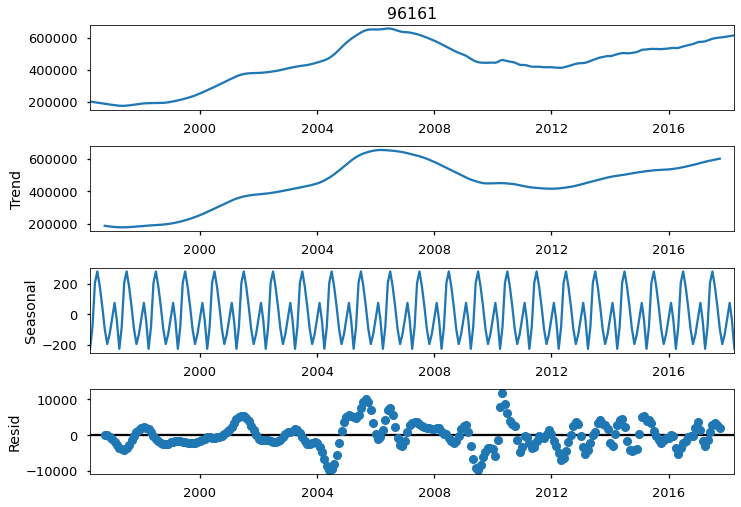

In [62]:
## Pldot decomp again for convenient comparison
decomp.plot();

# Step 5: ARIMA Modeling

# Step 6: Interpreting Results